In [5]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns
import pandas as pd

In [57]:
#8*1000 random vars, 8 input vectors/features
xjs_unif = np.random.uniform(-1.,1.,(8,100))
xjs_norm = np.random.normal(0,0.4,(8,100))

#8 uniform coefficients of sine function for the 8 functions
phi = np.linspace(np.pi/10,np.pi,8)
#compute input of sines = phij*xj for each j
inp_unif = []
inp_norm = []
for i in range(8):
    inp_unif.append(phi[i]*xjs_unif[i,:])
    inp_norm.append(phi[i]*xjs_norm[i,:])
inp_unif = np.array(inp_unif)
inp_norm = np.array(inp_norm)
sines_unif = np.sin(inp_unif)
sines_norm = np.sin(inp_norm)

#compute function coeffs Aj by finding the std of sin(phij*xj) and taking 1/std(sin(phij*xj))
fjunif = []
fjnorm = []
for i in range(8):
    fjunif.append(sines_unif[i,:]/np.std(sines_unif[i,:]))
    fjnorm.append(sines_norm[i,:]/np.std(sines_norm[i,:]))
fjunif = np.array(fjunif)
fjnorm = np.array(fjnorm)

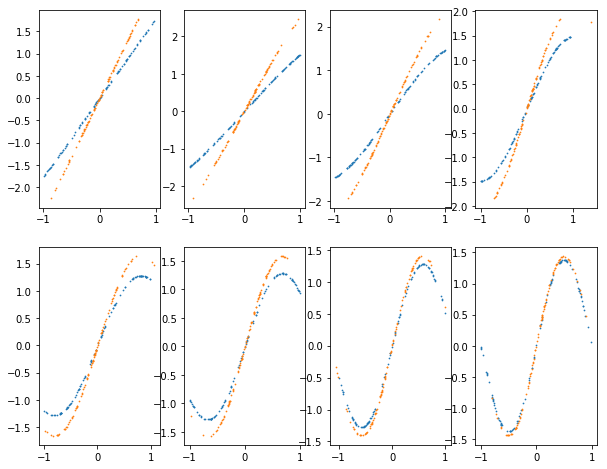

In [58]:
fig,ax = plt.subplots(2,4,figsize=(10,8))
ax = ax.ravel()
for i in range(8):
    ax[i].scatter(xjs_unif[i,:],fjunif[i,:],s=0.5)
    ax[i].scatter(xjs_norm[i,:],fjnorm[i,:],s=0.5)

In [59]:
#this is a multidimensional Yvector, the plot will not make sense
yvar = 0
for i in range(8):
    yvar = yvar + fjunif[i,:]
noisevec = np.random.normal(0,0.3,100) 
yvar = yvar + noisevec

In [60]:
from theano import shared
xshared = shared(xjs_unif.T)


In [61]:
with pm.Model() as model1:
    # priors on the covariance function hyperparameters
    #l = pm.Gamma('l', alpha=2, beta=1)
    l = pm.Uniform('l', 0., 10.,shape=8)
    # uninformative prior on the function variance
    s2_f = pm.HalfCauchy('s2_f', beta=2.)
    const = pm.Uniform('const',0.,10.)
    f_cov = s2_f**2 * pm.gp.cov.ExpQuad(input_dim=8, ls=l)
    mgp = pm.gp.Marginal(cov_func=f_cov+const)
    y_obs = mgp.marginal_likelihood('y_obs', X=xshared, y=yvar, noise=noisevec, is_observed=True)

In [62]:
with model1:
    trace = pm.sample(1000,tune=100,chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Shaan Desai\Anaconda3\envs\am207\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Sequential sampling (1 chains in 1 job)
NUTS: [const_interval__, s2_f_log__, l_interval__]
100%|██████████████████████████████████████████████████████████████████████████████| 1100/1100 [04:28<00:00,  4.10it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


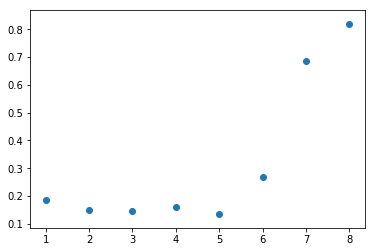

In [63]:
plt.figure()
plt.scatter(range(1,9),1/trace['l'].mean(axis=0),label='ARD')

In [64]:
with model1:
    gp_samples = pm.sample_ppc(trace, samples=200)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 33.77it/s]


In [65]:
origppc = np.copy(gp_samples['y_obs'])

In [66]:
origppc.shape

(200, 100)

In [67]:
xu = np.copy(xjs_unif)

In [68]:
zp = np.array([[1,2],[1,2]])

In [69]:
zp[:,0]=zp[:,0]+1

In [70]:
np.std(xjs_unif)

0.59651749322091

In [132]:
deltappcup = []
deltappcdn = []
delta = np.std(xjs_unif)*0.0001
for i in range(8):
    xu = np.copy(xjs_unif)
    xd = np.copy(xjs_unif)
    xu = xu.T
    xd = xd.T
    xu[:,i] = xu[:,i] + delta  
    xd[:,i] = xd[:,i] - delta
    xshared.set_value(xu)
    deltappcup.append(pm.sample_ppc(trace,samples=200,model = model1))
    xshared.set_value(xd)
    deltappcdn.append(pm.sample_ppc(trace,samples=200,model = model1))
    

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 298.83it/s]


In [133]:
origppc.shape
origmu = origppc.mean(axis=0)
origs = origppc.std(axis=0)

In [134]:
np.sqrt(2*KL(origmu,origs,deltappcup[7]['y_obs'].mean(axis=0),deltappcup[7]['y_obs'].std(axis=0))).mean()

0.11760998933793095

In [135]:
def KL(mu1,s1,mu2,s2):
    return (np.log(s2/s1) +(s1**2+(mu1-mu2)**2)/(2*s2**2)- 1./2)

def r(mu1,s1,mu2,s2):
    return (np.sqrt(2*KL(mu1,s1,mu2,s2))/delta)


In [136]:
rup = []
rdn = []
for i in range(8):
    rup.append(r(origmu,origs,deltappcup[i]['y_obs'].mean(axis=0),deltappcup[i]['y_obs'].std(axis=0)))
    rdn.append(r(origmu,origs,deltappcdn[i]['y_obs'].mean(axis=0),deltappcdn[i]['y_obs'].std(axis=0)))

In [137]:
rup = np.array(rup)
rdn = np.array(rdn)

In [138]:
rupmean = rup.mean(axis=1)

In [139]:
rdnmean = rdn.mean(axis=1)